# Cargamos los datos, separamos en train, validation y test. Y Añadimos el ruido con ayuda de una ia de generacion

**Prompt: "Generate code to add Gaussian noise of snr 3db to the fashion mnist database, and also add salt and pepper noise 
In the end my data would consist on the clean fashion mnist db, the gaussian contamined fashion mnist db, and the salt and pepper contamined fashion mnist db"**

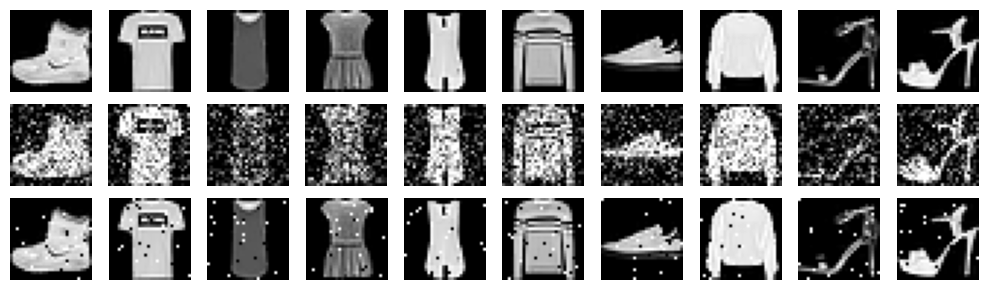

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize images to [0,1] range
x_train_full = x_train.astype(np.float32) / 255.0
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
x_test = x_test.astype(np.float32) / 255.0
y_train, y_valid = y_train[:-5000], y_train[-5000:]

# Function to add Gaussian noise with a given SNR in dB
def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    
    noise = np.random.normal(0, noise_std, images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0, 1)  # Ensure values remain in [0,1]

# Function to add Salt & Pepper noise
def add_salt_and_pepper_noise(images, salt_prob=0.02, pepper_prob=0.02):
    noisy_images = np.copy(images)
    total_pixels = images.shape[1] * images.shape[2]

    # Salt noise (white pixels)
    for img in noisy_images:
        num_salt = int(salt_prob * total_pixels)
        coords = [np.random.randint(0, i, num_salt) for i in img.shape]
        img[coords[0], coords[1]] = 1.0

    # Pepper noise (black pixels)
    for img in noisy_images:
        num_pepper = int(pepper_prob * total_pixels)
        coords = [np.random.randint(0, i, num_pepper) for i in img.shape]
        img[coords[0], coords[1]] = 0.0

    return noisy_images

# Generate noisy datasets
x_train_gaussian = add_gaussian_noise(x_train, snr_db=3)
x_valid_gaussian = add_gaussian_noise(x_valid, snr_db=3)
x_test_gaussian = add_gaussian_noise(x_test, snr_db=3)

x_train_saltpepper = add_salt_and_pepper_noise(x_train)
x_valid_saltpepper = add_salt_and_pepper_noise(x_valid)
x_test_saltpepper = add_salt_and_pepper_noise(x_test)


# Display sample images
fig, axs = plt.subplots(3, 10, figsize=(10, 3))

for i in range(10):
    axs[0, i].imshow(x_train[i], cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(x_train_gaussian[i], cmap="gray")
    axs[1, i].axis("off")
    axs[2, i].imshow(x_train_saltpepper[i], cmap="gray")
    axs[2, i].axis("off")

axs[0, 0].set_ylabel("Clean", fontsize=12)
axs[1, 0].set_ylabel("Gaussian", fontsize=12)
axs[2, 0].set_ylabel("Salt & Pepper", fontsize=12)

plt.tight_layout()
plt.show()

# Creamos el conjunto de etiquetas basadas en genero (Hombre, Mujer, Unisex)
**Prompt: I also need 2 outputs, the normal classification of the 10 classes in fashion mnist, and a classification of the clothes in men, women, and unisex clothes.
For that I need another Y array that serves for that classification. Help me with it"**

In [3]:
# Mapping classes to new categories (Men: 0, Women: 1, Unisex: 2)
category_map = {
    0: 2,  # T-shirt/top -> Unisex
    1: 2,  # Trouser -> Unisex
    2: 2,  # Pullover -> Unisex
    3: 1,  # Dress -> Women
    4: 2,  # Coat -> Unisex
    5: 1,  # Sandal -> Women
    6: 0,  # Shirt -> Men
    7: 0,  # Sneaker -> Men
    8: 1,  # Bag -> Women
    9: 1   # Ankle boot -> Women
}

# Apply mapping to training and test labels
y_train_category = np.array([category_map[label] for label in y_train])
y_valid_category = np.array([category_map[label] for label in y_valid])
y_test_category = np.array([category_map[label] for label in y_test])


# Print sample counts per category
unique, counts = np.unique(y_train_category, return_counts=True)
print("Training set category distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(y_valid_category, return_counts=True)
print("Validation set category distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(y_test_category, return_counts=True)
print("Test set category distribution:", dict(zip(unique, counts)))

Training set category distribution: {0: 11083, 1: 21952, 2: 21965}
Validation set category distribution: {0: 917, 1: 2048, 2: 2035}
Test set category distribution: {0: 2000, 1: 4000, 2: 4000}


# Definición del la arquitectura

In [4]:
#Seed para evitar el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)
#definimos el tamaño del batch
batch=64
#Definimos una funcion para crear el encoder con la API funcional
def build_autoencoder(latent_dim):
    Inputs_1 = tf.keras.layers.Input(shape=(28, 28, 1))
    Inputs_2 = tf.keras.layers.Input(shape=(28, 28, 1))
    Inputs_3 = tf.keras.layers.Input(shape=(28, 28, 1))
    h1_0 = tf.keras.layers.Conv2D(32, 3, activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(Inputs_1)
    dout1_0 = tf.keras.layers.Dropout(rate=0.2)(h1_0)
    bn1_0 = tf.keras.layers.BatchNormalization()(dout1_0)
    h2_0 = tf.keras.layers.Conv2D(32, 3, activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(Inputs_2)
    dout2_0 = tf.keras.layers.Dropout(rate=0.2)(h2_0)
    bn2_0 = tf.keras.layers.BatchNormalization()(dout2_0)
    h3_0 = tf.keras.layers.Conv2D(32, 3, activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(Inputs_3)
    dout3_0 = tf.keras.layers.Dropout(rate=0.2)(h3_0)
    bn3_0 = tf.keras.layers.BatchNormalization()(dout3_0)
    
    h1_1 = tf.keras.layers.Conv2D(64, 3, name="cnn_1", activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn1_0)
    dout1_1 = tf.keras.layers.Dropout(rate=0.2)(h1_1)
    bn1_1 = tf.keras.layers.BatchNormalization()(dout1_1)
    h2_1 = tf.keras.layers.Conv2D(64, 3, name="cnn_2", activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn2_0)
    dout2_1 = tf.keras.layers.Dropout(rate=0.2)(h2_1)
    bn2_1 = tf.keras.layers.BatchNormalization()(dout2_1)
    h3_1 = tf.keras.layers.Conv2D(64, 3, name="cnn_3", activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn3_0)
    dout3_1 = tf.keras.layers.Dropout(rate=0.2)(h3_1)
    bn3_1 = tf.keras.layers.BatchNormalization()(dout3_1)
    
    f1 = tf.keras.layers.Flatten()(bn1_1)
    f2 = tf.keras.layers.Flatten()(bn2_1)
    f3 = tf.keras.layers.Flatten()(bn3_1)
    
    conc = tf.keras.layers.Concatenate()([f1,f2,f3])
    h_2 = tf.keras.layers.Dense(128, activation='elu',kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(conc)
    dout2 = tf.keras.layers.Dropout(rate=0.2)(h_2)
    bn2 = tf.keras.layers.BatchNormalization()(dout2)
    h_3 = tf.keras.layers.Dense(latent_dim, activation='elu',name='latent_space',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn2)
    #dout3 = tf.keras.layers.Dropout(rate=0.2)(h_3)
    #bn3 = tf.keras.layers.BatchNormalization()(dout3)
    h_4 = tf.keras.layers.Dense(7*7*64, activation='elu', name='Decoder_input')(h_3)
    dout4 = tf.keras.layers.Dropout(rate=0.2)(h_4)
    bn4 = tf.keras.layers.BatchNormalization()(dout4)
    reshape = tf.keras.layers.Reshape((7, 7, 64))(bn4)
    h_5 = tf.keras.layers.Conv2DTranspose(64, 3, activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(reshape)
    dout5 = tf.keras.layers.Dropout(rate=0.2)(h_5)
    bn5 = tf.keras.layers.BatchNormalization()(dout5)
    h_6 = tf.keras.layers.Conv2DTranspose(32, 3, activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn5)
    
    out_1 = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same',name='output_reconstruccion')(h_6)
    
    class_dense1_1 = tf.keras.layers.Dense(500, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(h_3)
    dout6 = tf.keras.layers.Dropout(rate=0.2)(class_dense1_1)
    bn6 = tf.keras.layers.BatchNormalization()(dout6)
    
    class_dense2_1 = tf.keras.layers.Dense(500, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(h_3)
    dout7 = tf.keras.layers.Dropout(rate=0.2)(class_dense2_1)
    bn7 = tf.keras.layers.BatchNormalization()(dout7)
    
    class_dense1_2 = tf.keras.layers.Dense(100, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn6)
    class_dense2_2 = tf.keras.layers.Dense(100, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn7)

    
    out_2 = tf.keras.layers.Dense(10,activation="softmax",name='output_class_10')(class_dense1_2)
    out_3 = tf.keras.layers.Dense(3,activation="softmax",name='output_class_3')(class_dense2_2)
    
    autoencoder = tf.keras.Model([Inputs_1,Inputs_2,Inputs_3], [out_1, out_2,out_3], name='Autoencoder')
    return autoencoder

latent_dim=32
model= build_autoencoder(latent_dim)
model.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 14, 14, 32)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 14, 14, 32)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 14, 14, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 14, 14, 32)     │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 14, 14, 32)     │            128 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 14, 14, 32)     │            128 │ dropout_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_1 (Conv2D)            │ (None, 7, 7, 64)       │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_2 (Conv2D)            │ (None, 7, 7, 64)       │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_3 (Conv2D)            │ (None, 7, 7, 64)       │         18,496 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 7, 7, 64)       │              0 │ cnn_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 7, 7, 64)       │              0 │ cnn_2[0][0]            │
├──────────────────────

 Total params: 1,577,074 (6.02 MB)

 Trainable params: 1,567,842 (5.98 MB)

 Non-trainable params: 9,232 (36.06 KB)

In [5]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.1, s=60)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.5), loss=["mse","sparse_categorical_crossentropy","sparse_categorical_crossentropy"],metrics=["accuracy","accuracy","accuracy"])

history=model.fit([x_train,x_train_gaussian,x_train_saltpepper], [x_train,y_train,y_train_category], epochs=5, batch_size=batch, validation_data=([x_valid,x_valid_gaussian,x_valid_saltpepper], [x_valid,y_valid,y_valid_category]),callbacks=[lr_scheduler])

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - loss: 299.7956 - output_class_10_accuracy: 0.3499 - output_class_10_loss: 2.8613 - output_class_3_accuracy: 0.6099 - output_class_3_loss: 1.7810 - output_reconstruccion_accuracy: 0.4982 - output_reconstruccion_loss: 0.2007 - val_loss: 186.9673 - val_output_class_10_accuracy: 0.3380 - val_output_class_10_loss: 1.6169 - val_output_class_3_accuracy: 0.6846 - val_output_class_3_loss: 0.7264 - val_output_reconstruccion_accuracy: 0.4729 - val_output_reconstruccion_loss: 0.1524 - learning_rate: 0.1000
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 178.7882 - output_class_10_accuracy: 0.4156 - output_class_10_loss: 1.4428 - output_class_3_accuracy: 0.6591 - output_class_3_loss: 0.7693 - output_reconstruccion_accuracy: 0.4874 - output_reconstruccion_loss: 0.1440 - val_loss: 180.9040 - val_output_class_10_accuracy: 0.2402 - val_output_class_10_loss: 2.1210 - val_output_class_3_accuracy: 0.6492 - val_output_class_3_loss: 0.9197 - 

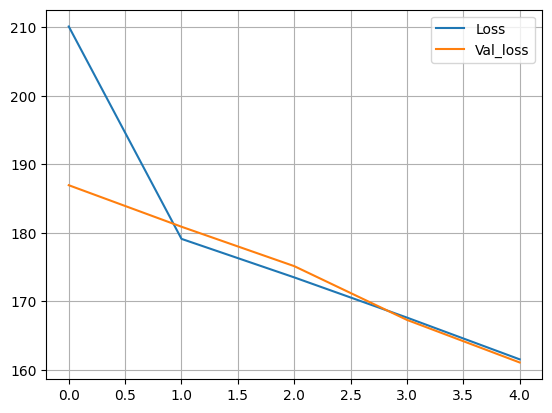

In [8]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

# Prediccion y visualizacion de resultados

In [12]:
x_pred,y_pred_10,y_pred_3 = model.predict([x_test,x_test_gaussian,x_test_saltpepper])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [13]:
y_pred_3 = np.argmax(y_pred_3, axis=1)
y_pred_10 = np.argmax(y_pred_10, axis=1)

**Matriz de confusion para 3 clases**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_category, y_pred_3)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix 3 classes")
plt.show()

**Matriz de confusion para 10 clases**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_10)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix 10 classes")
plt.show()

**Reporte de clasificacion para 3 clases**

In [39]:
from sklearn.metrics import classification_report
report = classification_report(y_test_category, y_pred_3)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2000
           1       1.00      0.00      0.00      4000
           2       0.40      1.00      0.57      4000

    accuracy                           0.40     10000
   macro avg       0.47      0.33      0.19     10000
weighted avg       0.56      0.40      0.23     10000



**Reporte de clasificacion para 10 clases**

In [40]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_10)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.10      1.00      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



# Umap del espacio latente

In [13]:
!pip install umap-learn #librería umap
!pip install datashader bokeh holoviews #gráficos umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


**Creamos un modelo parcial con la salida del espacio latente**

In [41]:
latent_space_model =  tf.keras.Model(inputs=model.input, outputs=model.get_layer("latent_space").output)
latent_space_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 14, 14, 32)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 14, 14, 32)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 14, 14, 32)     │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 14, 14, 32)     │            128 │ dropout_11[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 14, 14, 32)     │            128 │ dropout_12[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 14, 14, 32)     │            128 │ dropout_13[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_1 (Conv2D)            │ (None, 7, 7, 64)       │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_2 (Conv2D)            │ (None, 7, 7, 64)       │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_3 (Conv2D)            │ (None, 7, 7, 64)       │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 7, 7, 64)       │              0 │ cnn_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout) 

 Total params: 1,266,592 (4.83 MB)

 Trainable params: 1,265,760 (4.83 MB)

 Non-trainable params: 832 (3.25 KB)

In [42]:
latent_data = latent_space_model.predict([x_test,x_test_gaussian,x_test_saltpepper])
latent_data.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(10000, 32)

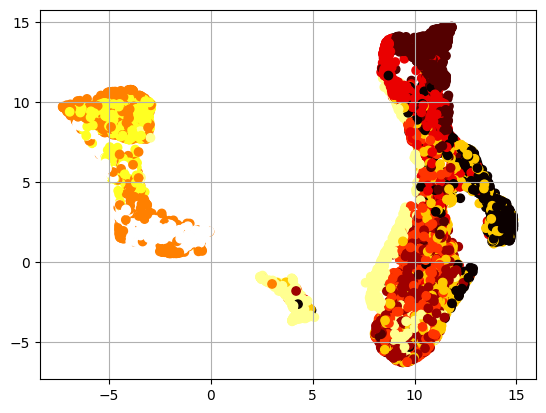

In [43]:
import umap
import umap.plot
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(latent_data)

red = umap.UMAP(n_components=2,n_neighbors=40, min_dist=0.2)
X_reduced_umap = red.fit_transform(data)
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y_test, cmap=plt.cm.hot)
plt.grid(True)
plt.show()

# CAMs para visualizar si el aporte viene de las entradas ruidosas o de las limpias

In [26]:
#-------------------------------------------------------------------------------
!pip install tf-keras-vis tensorflow

In [44]:
import scipy.io as sio
import pickle
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from sklearn.model_selection import ShuffleSplit
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#--------------------------------------------

In [52]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create a new model that selects only one classification output
model_classification = tf.keras.Model(inputs=model.input, outputs=model.get_layer("output_class_10").output)
# Function to generate GradCAM++ heatmaps
def generate_gradcam_plus_plus(model, images, class_idx, layer_names):
    # Set model modifier (replaces the last activation function with linear for better visualization)
    model_modifier = ReplaceToLinear()

    # Score function: targets the selected class
    score = CategoricalScore([class_idx])  # Select class index

    # GradCAM++ instance
    gradcam = GradcamPlusPlus(model, model_modifier=model_modifier, clone=True)

    # Generate GradCAM++ heatmaps
    heatmaps = {}
    for layer_name in layer_names:
        heatmap = gradcam(score, images, penultimate_layer=layer_name, normalize_cam=True)
        heatmaps[layer_name] = heatmap[0]  # Extract first sample
    return heatmaps

# Function to plot GradCAM++ heatmaps
def plot_gradcam(heatmaps, images, layer_names):
    fig, axes = plt.subplots(len(layer_names), 2, figsize=(8, 4 * len(layer_names)))

    if len(layer_names) == 1:
        axes = [axes]  # Convert to list for consistency

    for i, layer_name in enumerate(layer_names):
        heatmap = heatmaps[layer_name]
        
        # Original Image
        axes[i][0].imshow(images[0, :, :, 0], cmap='gray')  # First sample
        axes[i][0].set_title("Original Image")
        axes[i][0].axis("off")

        # Heatmap Overlay
        axes[i][1].imshow(images[0, :, :, 0], cmap='gray')
        axes[i][1].imshow(heatmap, cmap='jet', alpha=0.5)
        axes[i][1].set_title(f"GradCAM++ ({layer_name})")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:

# Sample image (Using a batch of 1 from x_train)
sample_image = np.expand_dims(x_train[0], axis=0)  # Shape -> (1, 28, 28, 1)

print(sample_image.shape)
# Since the model expects 3 inputs, we pass the same image three times
sample_inputs = [sample_image, sample_image, sample_image]

# Define layers to visualize
layer_names = ["cnn_1", "cnn_2", "cnn_3"]

# Select a class index for visualization (e.g., class 0)
class_idx = 0

# Generate GradCAM++ heatmaps
heatmaps = generate_gradcam_plus_plus(model_classification, sample_inputs, class_idx, layer_names)

# Plot the results
plot_gradcam(heatmaps, sample_images[0], layer_names)


In [45]:
#attention maps wide models
#attention maps
from mpl_toolkits.axes_grid1 import make_axes_locatable

def centroid_(X):
   D = pairwise_distances(X, X.mean(axis=0).reshape(1,-1))
   inertia_ = D.mean()
   return np.argmin(D),inertia_

def plot_attention(tmpr_,layer_name,list_class,figsize=(10,5), transpose=False):


    if transpose:
      x_label_list = layer_name
      nC = len(list_class)
      nl = len(layer_name)
      ncols,nrows = tmpr_.shape

      y_label_list = []
      for ii in range(nC):
          y_label_list += str(list_class[ii])

      dw = nrows/nl
      list_xticks = []
      for ii in range(nl):
        list_xticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_yticks = []
      for ii in range(nC):
        list_yticks += [int(dw*(0.5+ii))]

    else:
      y_label_list = layer_name
      nC = len(list_class)
      nl = len(layer_name)
      nrows,ncols = tmpr_.shape

      x_label_list = []
      for ii in range(nC):
          x_label_list += str(list_class[ii])

      dw = nrows/nl
      list_yticks = []
      for ii in range(nl):
        list_yticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_xticks = []
      for ii in range(nC):
        list_xticks += [int(dw*(0.5+ii))]

    plt.figure(figsize=figsize)
    ax = plt.gca()
    im = ax.imshow(tmpr_)
    im = ax.imshow(tmpr_)
    ax.set_yticks(list_yticks)
    ax.set_yticklabels(y_label_list)
    ax.set_xticks(list_xticks)
    ax.set_xticklabels(x_label_list,rotation = 'vertical') #
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    plt.colorbar(im, cax=cax,extend='both',
                 ticks=[np.round(tmpr_.min(),1), np.round(0.5*(tmpr_.max()-tmpr_.min()),1), np.round(tmpr_.max(),1)])
    #plt.yticks(rotation=45)


    plt.tight_layout()
    plt.show()
    return

def attention_wide(modelw,rel_model_name,layer_name,X_train,y_train,
                   normalize_cam=False,norm_max_min=False,norm_c=True,
                   plot_int=False,centroid_=False,smooth_samples=20,
                   smooth_noise=0.20,transpose=False):
    #-------------------------------------------------------------------------------
    # define trial sample to visualize
    # change activations of last layer by linear
    replace2linear = ReplaceToLinear()
    #relevance model

    if rel_model_name == 'Gradcam':
        gradcamw = Gradcam(modelw,
                        model_modifier=replace2linear,
                        clone=True)
    elif rel_model_name == 'Gradcam++':
        gradcamw = GradcamPlusPlus(modelw,
                              model_modifier=replace2linear,
                              clone=True)

    elif rel_model_name == 'Scorecam':
        scorecamw = Scorecam(modelw)

    elif rel_model_name == 'Saliency':
          saliencyw = Saliency(modelw,
                              model_modifier=replace2linear,
                              clone=True)
          layer_name = [''] #saliency doesn't depend on different layers
    nC = len(np.unique(y_train))
    relM = [None]*nC
    if type(X_train)==list:
        n_inputs = len(X_train)
        new_input = [None]*n_inputs

    for c in range(len(np.unique(y_train))):
      id_sample = y_train == np.unique(y_train)[c]

      if (type(X_train)==list) and (rel_model_name != 'Saliency'):
        relM[c] = np.zeros((sum(id_sample),X_train[0].shape[1],X_train[0].shape[2],len(layer_name)))
        #print(1,relM[c].shape)
      elif (type(X_train)==list) and (rel_model_name == 'Saliency'):
        relM[c] = np.zeros((sum(id_sample),X_train[0].shape[1],X_train[0].shape[2],len(X_train)))
        #print(2,relM[c].shape)
      else:
        relM[c] = np.zeros((sum(id_sample),X_train.shape[1],X_train.shape[2],len(layer_name)))
        #print(3,relM[c].shape)
      score = CategoricalScore(list(y_train[id_sample])) #-> [0] para probar a una clase diferente
      if type(X_train)==list:
          for ni in range(n_inputs):
              new_input[ni] = X_train[ni][id_sample]
      else:
        new_input = X_train[id_sample]
      #print('rel',rel_model_name,'layer',layer_name[l])
      for l in range(len(layer_name)):
          print(rel_model_name,'class', np.unique(y_train)[c],'layer',layer_name[l])
      # label score -> target label accoring to the database
      #-----------------------------------------------------------------------------
      # generate heatmap with GradCAM
          if (rel_model_name == 'Gradcam') or (rel_model_name == 'Gradcam++'):
              rel = gradcamw(score,
                          new_input,
                          penultimate_layer=layer_name[l], #layer to be analized
                          expand_cam=True,
                          normalize_cam=normalize_cam)
          elif rel_model_name == 'Saliency': #saliency map is too noisy, so let’s remove noise in the saliency map using SmoothGrad!
                rel = saliencyw(score, new_input,smooth_samples=smooth_samples,
                                smooth_noise=smooth_noise,normalize_map=normalize_cam) #, smooth_samples=20,smooth_noise=0.20) # The number of calculating gradients iterations.

          elif rel_model_name == 'Scorecam':
              rel = scorecamw(score, new_input, penultimate_layer=layer_name[l], #layer to be analized
                          expand_cam=True,
                          normalize_cam=normalize_cam) #max_N=10 -> faster scorecam

          #save model

          if rel_model_name != 'Saliency':
            if type(X_train)==list:
              tcc = rel[0]
            else:
              tcc = rel
            dimc = tcc.shape
            tccv = tcc.ravel()
            tccv[np.isnan(tccv)] = 0
            tcc = tccv.reshape(dimc)
            if norm_max_min: #normalizing along samples
              tcc = MinMaxScaler().fit_transform(tcc.reshape(dimc[0],-1).T).T
              tcc = tcc.reshape(dimc)
            relM[c][...,l] = tcc
            if l==0:
              tmp = np.median(relM[c][...,l],axis=0)#relM[c][...,l].mean(axis=0)
            else:
              if transpose:
                tmp = np.c_[tmp,np.median(relM[c][...,l],axis=0)]#np.r_[tmp,relM[c][...,l].mean(axis=0)]  #centroid
              else:
                tmp = np.r_[tmp,np.median(relM[c][...,l],axis=0)]#np.r_[tmp,relM[c][...,l].mean(axis=0)]  #centroid
          else: #saliency
            if type(X_train)==list:
              tcc = np.zeros((rel[0].shape[0],rel[0].shape[1],rel[0].shape[2],len(rel)))
              for ii in range(len(rel)):
                  tcc[...,ii] = rel[ii]
            else:
              tcc = rel
            dimc = tcc.shape
            tccv = tcc.ravel()
            tccv[np.isnan(tccv)] = 0
            tcc = tccv.reshape(dimc)
            if norm_max_min: #normalizing along samples
              tcc = MinMaxScaler().fit_transform(tcc.reshape(dimc[0],-1).T).T
              tcc = tcc.reshape(dimc)
            relM[c] = tcc
            if type(X_train)==list:
              tmp = np.median(tcc[...,0],axis=0)
              for ii in range(len(rel)-1):
                  if transpose:
                    tmp = np.c_[tmp,np.median(tcc[...,ii+1],axis=0)]
                  else:
                    tmp = np.r_[tmp,np.median(tcc[...,ii+1],axis=0)]
            else:
               tmp = np.median(tcc,axis=0)

      if norm_c: #normalizing along layers
        tmp = tmp/(1e-8+tmp.max())
      if c==0:
        tmpr = tmp
      else:
        if transpose:
          tmpr = np.r_[tmpr,tmp]
        else:
          tmpr = np.c_[tmpr,tmp]
      #print(tmp.shape,tmp.max())
      if plot_int: #plot every class
         plt.imshow(tmp)
         plt.colorbar(orientation='horizontal')
         plt.axis('off')
         plt.show()
    tmpr = tmpr/(1e-8+tmpr.max())
    list_class = np.unique(y_train)
    plot_attention(tmpr,layer_name,list_class,transpose=transpose)

    return relM,tmpr

In [ ]:
rel_model_name = ['Gradcam++'] #Gradcam, Gradcam++, Saliency, Scorecam
layer_name = ['cnn1','cnn2','cnn3']
relM_ = [None]*len(rel_model_name) #relM[m] -> number classes x input image resolution x number of layers
tmpr_ = [None]*len(rel_model_name)
for m in range(len(rel_model_name)):
    relM_[m],tmpr_[m] = attention_wide(model_classification,rel_model_name[m],layer_name,x_train,y_train,
                                       norm_c=True,norm_max_min=True,plot_int=False,transpose=False)

In [ ]:
rel_model_name = ['Saliency','Gradcam++','Scorecam']#,'Scorecam','Saliency'] #Gradcam, Gradcam++, Saliency, Scorecam
layer_name = ['wcnn_00','wcnn_01','wcnn_10','wcnn_11','wcnn_20','wcnn_21']
relM_ = [None]*len(rel_model_name) #relM[m] -> number classes x input image resolution x number of layers
tmpr_ = [None]*len(rel_model_name) #relM[m] -> number classes x input image resolution x number of layers

for m in range(len(rel_model_name)):
    relM_[m],tmpr_[m] = attention_wide(model_dw,rel_model_name[m],layer_name,inputs_train,y_train,
                                     norm_c=False,norm_max_min=False,plot_int=False,transpose=True)